In [8]:
%matplotlib inline

import os

import pandas as pd
import tqdm
import networkx as nx

from scipy import interpolate
from scipy.stats import erlang
from scipy.integrate import odeint

import numpy as np
import pandas as pd

from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib import cm

import tqdm


def init_fig(aspect=(4,4),fontsize=12):
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)
    plt.rc('axes', labelsize=fontsize)
    params = {'legend.fontsize': 'larger',
              'legend.handlelength': 2}
    plt.rcParams.update(params)

    fig = plt.figure(figsize=aspect)
    ax = fig.add_subplot(1, 1, 1)
    return ax,fig



# Models

In [9]:
INIT_SUSCEPTIBLE = 0.002
SEIR_y0 = [1-INIT_SUSCEPTIBLE,INIT_SUSCEPTIBLE/2,INIT_SUSCEPTIBLE/2,0]
SIR_y0 = [1-INIT_SUSCEPTIBLE,INIT_SUSCEPTIBLE,0]
SEIR_erlang_y0 = [1-INIT_SUSCEPTIBLE,INIT_SUSCEPTIBLE/4,INIT_SUSCEPTIBLE/4,INIT_SUSCEPTIBLE/4,INIT_SUSCEPTIBLE/4,0]

def SIR_model(y,t,config,rfunc):
    """
    SIR model
    @y,t: - variables for the differential equations
    @config: include - rates beta,gamma for differential equations
    @rfunuc: a function that maps time to viral reproduction rate 
    """
    S,I,R = y
    Rt = rfunc(t)
    beta,gamma = config["beta"],config["gamma"]
    dydt = [-Rt*beta * (I*S),
            Rt*beta * (I*S) - gamma*I, 
            gamma*I]
    return dydt

def SEIR_model(y,t,config,rfunc):
    """
    SEIR model
    @y,t: - variables for the differential equations
    @config: include - rates beta,gamma for differential equations
    @rfunuc: a function that maps time to viral reproduction rate 
    """
    S,E,I,R = y
    Tinc,Tinf = config["Tinc"],config["Tinf"]
    Rt = rfunc(t)
    dydt = [-Rt/Tinf * (I*S),
            Rt/Tinf * (I*S) - (1/Tinc)*E, 
            (1/Tinc)*E - (1/Tinf)*I,
            (1/Tinf)*I]
    return dydt

def SEIR_erlang_model(y,t,config,rfunc):
    """
    SEIR model with erlang delays (shape 2) between exposure and infection, and infection and recovery
    @y,t: - variables for the differential equations
    @config: include - rates beta,gamma for differential equations
    @rfunuc: a function that maps time to viral reproduction rate 
    """
    S,E1,E2,I1,I2,R = y
    Tinc,Tinf = config["Tinc"]/2,config["Tinf"]/2
    Rt = rfunc(t)
    dydt = [-.5*Rt/Tinf * (I1+I2)*S,
            .5*Rt/Tinf * (I1+I2)*S - (1/Tinc)*E1, 
            (1/Tinc)*(E1-E2),
            (1/Tinc)*E2 - (1/Tinf)*I1,
            (1/Tinf)*(I1-I2),
            (1/Tinf)*I2]
    return dydt

def get_erlang_X_2_groups(X,leakage,phi=1):
    """
    This fuction generates differential equations for the staggered strategy,
    where the population is divided into two groups that are at lockdown/work
    on staggered schedules. 
    @X: - the shape of the erlang distribution
    @leakage: fraction of individuals that do not adhere to the lockdown of their group
    @phi: density compensation (1- no compensation, 2 - full compensation)
    """
    N_GROUPS = 2
    def func(y,t,config,rfuncs,Rw,Rl):
        groups = []
        for i in range(N_GROUPS):
            s = (2*X+2)*i
            groups.append ( {
                "S" : y[s],
                "E_ARR" : y[s+1:s+1+X],
                "I_ARR" : y[s+1+X:s+1+X+X],
                "R" : y[s+1+X+X]
            })
        Tinc,Tinf = config["Tinc"]/X,config["Tinf"]/X
        
        dydt = []
        # cross leakage
        I_ALL = sum([sum(groups[j]["I_ARR"]) for j in range(N_GROUPS)] )
        for j in range(N_GROUPS):
            Rt = rfuncs[j](t)
            Rt_other = rfuncs[(j +1 ) % N_GROUPS](t)
            Rw_nl = phi * (Rw - Rl)
            Rlock_eff = 2*Rl
            S, E_ARR, I_ARR, R = [groups[j][idx] for idx in ("S","E_ARR","I_ARR","R")]
            I_GRP = sum(I_ARR)
            I_OTHER = (I_ALL-I_GRP)
            if Rt<1:
                GRP_NEW_INFECT = Rlock_eff*I_GRP
                
                if Rt_other < 1:# no cross infectivity when both groups in lockdown
                    DEFECT_NEW_INFECT = 0
                    OUTSIDE_DEFECT_NEW_INFECT = 0 
                else:
                    DEFECT_NEW_INFECT = (leakage**2)*Rw_nl*I_GRP
                    OUTSIDE_DEFECT_NEW_INFECT = Rw_nl * leakage * I_OTHER

                NEW_INFECTIONS = (GRP_NEW_INFECT + DEFECT_NEW_INFECT + OUTSIDE_DEFECT_NEW_INFECT) * S
            else:
                # work time
                GRP_NEW_INFECT = (Rlock_eff + Rw_nl)  * I_GRP
                OUTSIDE_DEFECT_NEW_INFECT = Rw_nl * leakage * I_OTHER
                NEW_INFECTIONS = (GRP_NEW_INFECT + OUTSIDE_DEFECT_NEW_INFECT) * S
            dydt.append(-(1/X) *  (1/Tinf) * NEW_INFECTIONS)
            dydt.append((1/X) *  (1/Tinf) * NEW_INFECTIONS - (1/Tinc)*E_ARR[0])
            [dydt.append((1/Tinc)*(E_ARR[i]-E_ARR[i+1])) for i in range(X-1)]
            dydt.append((1/Tinc)*E_ARR[-1] - (1/Tinf)*I_ARR[0])
            [dydt.append((1/Tinf)*(I_ARR[i]-I_ARR[i+1])) for i in range(X-1)]
            dydt.append((1/Tinf) * I_ARR[-1])
            
        return dydt
    y0 = []
    for j in range(N_GROUPS):
        y0.append((1-INIT_SUSCEPTIBLE)/N_GROUPS)
        y0 = y0 + [((INIT_SUSCEPTIBLE/2)/X)/N_GROUPS for i in range(2*X)]
        y0.append(0)
    
    return func,y0

def run(model,config,y0,period,lockdown,Rw,Rl,tmax=30*4):
    """
    solves the model @model with initial conditions @y0 and using parameter config @config,
    with a cyclic strategy of total period @period and lockdown period @lockdown (e.g. period=14,lockdown=10)
    @Rw is work days viral reproduction rate and @Rl is lockdown days viral reproduction rate.
    @tmax is duration of the simulation
    """
    t = np.linspace(1,tmax,tmax)
    rfunc = lambda t:  Rw-(Rw-Rl)*((int(t)%period) < lockdown)
    rfunc = np.vectorize(rfunc)
    sol = odeint(model, y0, t,args=(config,rfunc), atol=1e-12, rtol=1e-12)
    
    return sol
def run_groups(model,config,y0,period,lockdown,offset,Rw,Rl,tmax = 30*4):
    """
    solves a group (staggered) model @model with initial conditions @y0 and using parameter config @config,
    with a cyclic strategy of total period @period and lockdown period @lockdown (e.g. period=14,lockdown=10)
    @Rw is work days viral reproduction rate and @Rl is lockdown days viral reproduction rate.
    @offset is offset between group active periods (usually 1 week)
    @tmax is duration of the simulation
    """
    def gen_func(OFF):
        return (lambda t:  Rw-(Rw-Rl)*(((int(t)+OFF)%period) < lockdown))
    t = np.linspace(1,tmax,tmax)
    rfuncs = [gen_func(OFF) for OFF in (0,offset)]
    rfuncs = [np.vectorize(rfunc) for rfunc in rfuncs]
    sol = odeint(model, y0, t,args=(config,rfuncs,Rw,Rl), atol=1e-12, rtol=1e-12)
    
    return sol



In [34]:
from sklearn.linear_model import LinearRegression

CPU times: user 250 ms, sys: 0 ns, total: 250 ms
Wall time: 332 ms


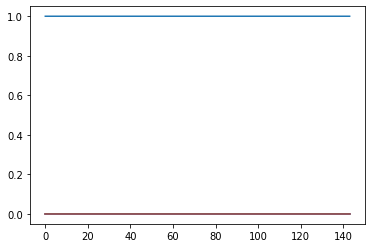

In [66]:
%%time
config = {'Tinc': 1, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}
# S,E1,E2,I1,I2,R = y
y0 = [1,1e-6,1e-6,1e-6,1e-6,0]
# SEIR_erlang_model(y0,0,config,lambda x: 1.5)
tmax=125+19
sol =run(SEIR_erlang_model,config,y0,14,10,1.5,0.6,tmax)
plt.plot(sol)

In [70]:
config = {'Tinc': 3, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}
# S,E1,E2,I1,I2,R = y
y0 = [1,1e-6,1e-6,1e-6,1e-6,0]
# SEIR_erlang_model(y0,0,config,lambda x: 1.5)
tmax=125+19
sol =run(SEIR_erlang_model,config,y0,14,10,1.5,0.6,tmax)

[[0.94610407]]
1.0


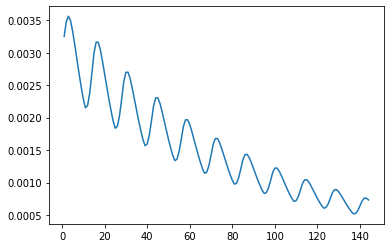

In [74]:
config = {'Tinc': 1, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}
# S,E1,E2,I1,I2,R = y
y0 = [1,1e-6,1e-6,1e-6,1e-6,0]
# SEIR_erlang_model(y0,0,config,lambda x: 1.5)
tmax=125+19
sol =run(SEIR_erlang_model,config,y0,14,10,1.5,0.6,tmax)
config2 = {'Tinc': 2, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}
sol2 =run(SEIR_erlang_model,config2,y0,14,10,1.5,0.6,tmax)
config3 = {'Tinc': 3, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}
sol3 =run(SEIR_erlang_model,config3,y0,14,10,2,0.6,tmax)
#     run(model,config,y0,period,lockdown,Rw,Rl,tmax=30*4):
t = np.linspace(1,tmax,tmax)
plt.plot(t,(sol3[:,3:5].sum(axis=1))/0.002*3.25)
# plt.plot(t,np.log(sol2[:,3:5].sum(axis=1)))
# plt.plot(t,np.log(sol3[:,3:5].sum(axis=1)))
linfit = LinearRegression()  
linfit.fit((t[19:]).reshape(-1,1), np.log(sol3[19:,3:5].sum(axis=1).reshape(-1,1))) 
print(np.exp(linfit.coef_*5))
# plt.xlim([0,12*7])
# plt.ylim([0,4])
print((2*4+0.6*10)/14)

In [41]:
sol[:,3:5].sum(axis=1)/0.002*3

array([3.        , 4.52001412, 4.65898048, 4.34548463, 3.94518589,
       3.54882137, 3.17947335, 2.84293499, 2.53942164, 2.26708061,
       2.23022681, 2.60115563, 3.15883951, 3.8587354 , 4.33656807,
       4.19277739, 3.84366265, 3.46612739, 3.10645898, 2.77631938,
       2.47778484, 2.20973174, 1.9699014 , 1.75571512, 1.72367431,
       2.00535878, 2.42967157, 2.96155466, 3.32270532, 3.20894477,
       2.93869238, 2.64726736, 2.37006355, 2.11594721, 1.88643595,
       1.68059952, 1.49664577, 1.33254598, 1.30635303, 1.51700988,
       1.83476839, 2.23272529, 2.50180688, 2.41410561, 2.20905385,
       1.98840797, 1.77877487, 1.58678972, 1.41355255, 1.25832284,
       1.1197157 , 0.99617326, 0.97553954, 1.13126588, 1.36642244,
       1.66073699, 1.85910987, 1.79280276, 1.63956033, 1.47492433,
       1.31864207, 1.1756211 , 1.04665484, 0.9311705 , 0.82811914,
       0.73632612, 0.72049751, 0.83464358, 1.00715617, 1.22296539,
       1.36808123, 1.31866982, 1.20543163, 1.08391552, 0.96863

# Model range

In [ ]:
def test_epidemic_suppression(callback,success_callback,Rw,Rl):
    """
    Here we test for a range of reproductive rates @Rw and @Rl whether the epidemic is
    suppressed. A metric for the model is outputted by a callback @callback, and whether 
    this led to successful suppression of the epidemic is tested by another callback
    """
    Rw_,Rl_ = np.meshgrid(Rw,Rl)
    # estimate output
    out = callback(Rw_,Rl_)
    
    # test for success
    df = pd.DataFrame(success_callback(out))
    for idx,row in df.iterrows():
        if row.min()==1:
            continue
        df.iloc[idx,row.idxmin()+1:]=False
    out = df.values
    
    # calculate and return contour line which represents the range in which the strategy is successful
    cs = plt.contour((1*(~out)),levels=[1])
    paths = cs.collections[0].get_paths()
    if len(paths)==0:
        return np.array([(Rw_[0][i],Rl_.max()) for i in range(out.shape[0])])
    path_ = paths[0]
    path = np.array([(Rw_[0][i],Rl_.max()) for i in range(path_.vertices[0][0].astype(int))] + 
                    [(Rw_[0][z.astype(int)[0]],Rl_[:,0][z.astype(int)[1]]) for z in path_.vertices])
    return path

def gen_diffeq_callback(model,config,y0,period,lockdown):
    """
    callback estimates model and returns the day with maximal numbers of individuals infected
    """
    @np.vectorize
    def func(Rw,Rl): 
        return np.argmax(run(model=model,config=config,y0=y0,period=period,lockdown=lockdown,Rw=Rw,Rl=Rl)[:,-2])
    return func

def gen_diffeq_callback_groups(model,config,y0,period,lockdown):
    """
    callback estimates model with 2 groups in antiphase and returns the day 
    with maximal numbers of individuals infected
    """    
    @np.vectorize
    def func(Rw,Rl): 
        return np.argmax(run_groups(model=model,config=config,y0=y0,
                                    period=period,lockdown=lockdown,offset = lockdown/2,Rw=Rw,Rl=Rl)[:,-2])
    return func

def gen_diffeq_success_callback(period):
    """the success criteria is that the maximal number of infected individuals occurs within the first period"""
    success = lambda out: out<=2*period
    return success

def gen_diffeq_groups_success_callback(period):
    """the success criteria is that the maximal number of infected individuals occurs within the first period"""
    success = lambda out: out<=2*period
    return success



In [ ]:
def do_interpolate(yy,Rw,Rl,k=None):
    if type(k)==type(None):
        tck = interpolate.splrep(yy[:,0], yy[:,1], s=1)
    else:
        tck = interpolate.splrep(yy[:,0], yy[:,1], s=1,k=k)
    xnew = np.linspace(.9, .01+Rw.max(), 100)
    ynew = interpolate.splev(xnew, tck, der=0)
    xnew_filt = (xnew>=.999*Rw.min()) &(xnew<=Rw.max()+1)
    ynew,xnew = ynew[xnew_filt],xnew[xnew_filt]
    return xnew,ynew   

def generate_sensitivity_plot(model,y0,Rw,Rl,period,lockdown_days,config,
                              confidence_interval_params=None,k=None,
                              suffix="",
                              callback=gen_diffeq_callback,
                              success_callback=gen_diffeq_success_callback):

    
    y = []
    for lockdown in tqdm.tqdm(lockdown_days):
        callback_ = callback(model,config,y0,period,lockdown)
        success_callback_ = success_callback(period)
        y.append(test_epidemic_suppression(callback_,success_callback_,Rw,Rl))
    if not type(confidence_interval_params)==type(None):
        lockdown = confidence_interval_params["lockdown"]
        conf_combs = []
        for i in confidence_interval_params["tinc_scale"]:
            for j in confidence_interval_params["tinf_scale"]:
                config_ = {'Tinc': config["Tinc"]*i, 'Tinf': config["Tinf"]*j}
                callback = gen_diffeq_callback(model,config_,y0,period,lockdown)
                success_callbck = gen_diffeq_success_callback(period)
                conf_combs.append(test_epidemic_suppression(callback,success_callbck,Rw,Rl))
    else:
        conf_combs = None
    
    model_name = model.__str__().split(" ")[1]
    output_sensitivity_plot(y,Rw,Rl,period,model_name,suffix,k,conf=conf_combs)
    return y

def output_sensitivity_plot(y,Rw,Rl,period,model_name="",suffix="",k=None,conf=None):

    ax,fig=init_fig(aspect=(4,4),fontsize=12)
    colors=plt.cm.Blues_r(np.linspace(0,1,len(y)+2))
    ax.fill_between([Rw.max(),Rw.min()],[1,1],color=colors[len(y)-1])
    for i in range(len(y)):
        yy = y[::-1][i]
        yy = np.array(yy)
        xnew,ynew = do_interpolate(yy,Rw,Rl,k)
        if ynew[0]<0:
            xnew,ynew = do_interpolate(yy,Rw,k=1)
        ax.fill_between(xnew,ynew,color=colors[i],interpolate=True)
    
    if not type(conf)==type(None):
        base = pd.concat([pd.DataFrame(x,columns=("X","Y")) for x in conf])
        xnew_max,ymax = do_interpolate(base.groupby("X").max().reset_index().values,Rw,k)
        xnew_min,ymin = do_interpolate(base.groupby("X").min().reset_index().values,Rw,k)
        comb = pd.merge(pd.DataFrame({"X": xnew_min,"Ymin" : ymin}),pd.DataFrame({"X": xnew_max,"Ymax" : ymax}),on="X")
        ax.fill_between(comb.X,y1=comb.Ymin,y2=comb.Ymax,color='gray',alpha=0.5)

    ax.set_ylim(Rl.max(),Rl.min())
    ax.set_xlim(Rw.max(),0.75)
    ax.set_ylabel("R (lockdown)")
    ax.set_xlabel("R (work days)")
    ax.vlines(1,0,1,linestyle='dashed')
    ax.fill_between([0,1],[1,1],color=colors[-1],interpolate=True)

    plt.tight_layout()
    
    plt.savefig(os.path.join(BASE_DIR,"plots","contures_%s_%s_%s%s.pdf" % (PERIOD,len(y),model_name,suffix)))


In [ ]:
config = {'Tinc': 3, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}

RES = 20
PERIOD = 14
Rw = np.linspace(1,3,RES)
Rl = np.linspace(0,1-1e-6,RES)

lockdown_days = [10,11,12,13,14]
y=generate_sensitivity_plot(SEIR_erlang_model,SEIR_erlang_y0,Rw,Rl,period=PERIOD,
                            lockdown_days=lockdown_days,config=config)


In [ ]:
# Gnerate for all work days
lockdown_days = range(3,15)
y=generate_sensitivity_plot(SEIR_erlang_model,SEIR_erlang_y0,Rw,Rl,period=PERIOD,
                            lockdown_days=lockdown_days,config=config,k=1)

In [ ]:
# Generate the same plot for SIR model
config = {'Tinc': 3, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}

RES = 20
PERIOD = 14
Rw = np.linspace(1,3,RES)
Rl = np.linspace(0,1-1e-6,RES)
lockdown_days = [10,11,12,13,14]

_=generate_sensitivity_plot(SIR_model,SIR_y0,Rw,Rl,period=PERIOD,
                            lockdown_days=lockdown_days,config=config,k=1)

In [ ]:
config = {'Tinc': 3, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}

RES = 20
PERIOD = 14
Rw = np.linspace(1,3,RES)
Rl = np.linspace(0,1-1e-6,RES)
lockdown_days = (10,11,12,13,14)


# staggered model
for rho in (0.1,0.3):
    for phi in (1,1.5):
        model,y0 = get_erlang_X_2_groups(2,leakage=rho,phi=phi)
        y=generate_sensitivity_plot(
            model,y0,Rw,Rl,period=PERIOD,lockdown_days = lockdown_days,
            config=config,suffix="STAGGERED_%.2f_%.2f" % (rho,phi),
            callback=gen_diffeq_callback_groups,
            success_callback=gen_diffeq_groups_success_callback)


In [ ]:
config = {'Tinc': 3, 'Tinf': 4, 'beta': 1/7, 'gamma': 1/7}

RES = 10
PERIOD = 14
Rw = np.linspace(1,3,RES)
Rl = np.linspace(0,1-1e-6,RES)
lockdown_days = (10,11,12,13,14)


# staggered model
for rho in (0.1,0.3):
    for phi in (1,1.5):
        model,y0 = get_erlang_X_2_groups(2,leakage=rho,phi=phi)
        y=generate_sensitivity_plot(
            model,y0,Rw,Rl,period=PERIOD,lockdown_days = lockdown_days,
            config=config,suffix="STAGGERED_%.2f_%.2f" % (rho,phi),
            callback=gen_diffeq_callback_groups,
            success_callback=gen_diffeq_groups_success_callback,k=1)


In [ ]:
#confidence intervals
conf_parms = {"lockdown" : 10, "tinc_scale" : (2.5/3,1,4/3), "tinf_scale" : (3/4,1,8/4)}
RES = 20
PERIOD = 14
Rw = np.linspace(1,3,RES)
Rl = np.linspace(0,1-1e-6,RES)

_=generate_sensitivity_plot(SEIR_erlang_model,SEIR_erlang_y0,Rw,Rl,period=PERIOD,
                            lockdown_days=(10,14),config=config,suffix="TEST",
                            confidence_interval_params=conf_parms)

# Social network

In [ ]:
def graph_run(G,config,weight_attr='weight_const',period=7,lockdown=0,tmax=30*4,INIT_NUM=50):
    ERLANG_SHAPE = 2
    I = set([list(G.nodes())[i] for i in np.random.choice(range(len(list(G.nodes()))),INIT_NUM)])
    S = set(list(G.nodes())).difference(I)
    E = set()
    R = set()
    
    EXPOSE_TIME = dict()
    INFECT_TIME = dict()
    for i in I:
        INFECT_TIME[i] = erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinf"]/ERLANG_SHAPE)
    sol=[]
    for day in range(tmax):
        
        I_new = set()
        E_new = set()
        R_new = set()
        
        # new infecting
        for e in E:
            if EXPOSE_TIME[e]-day <= 0:
                I_new.add(e)
                INFECT_TIME[e] = day + erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinf"]/ERLANG_SHAPE)
        for i in I:
            in_isolation = (((day%period) < lockdown))
            # new exposed
            for neighbor in G.neighbors(i):
                if in_isolation and not G.get_edge_data(i,neighbor)['lockdown_neighbor']:
                    continue
                
                if neighbor in S and np.random.rand() < G.get_edge_data(i,neighbor)[weight_attr]:
                    E_new.add(neighbor)
                    EXPOSE_TIME[neighbor] = day + erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinc"]/ERLANG_SHAPE)
            # new recovered
            
            if INFECT_TIME[i]-day <=0:
                R_new.add(i)

                
        S = S.difference(E_new)
        E = E.union(E_new).difference(I_new)
        I = I.union(I_new).difference(R_new)
        R = R.union(R_new)
        sol.append(np.array([len(x) for x in (S,E,I,R)]))

    return np.array(sol)

def calculate_graph_sol(G,mode,config,period,lockdown,INIT_NUM=50,iterations=10,tmax=30*4):
    sol = [graph_run(G,config,weight_attr=mode,
                    period=period,lockdown=lockdown,INIT_NUM=INIT_NUM,tmax=tmax)
               for j in range(iterations)]
    sol=np.mean(sol,axis=0)
    return sol

In [ ]:
def load_small_world_graph(config,N = 10000,k=16,Rw=1.5,Rl=0.6):
    beta=1-Rl/Rw
    G = nx.watts_strogatz_graph(N,k,beta)
    attrs = dict()
    for edge in G.edges():
        attrs[edge] = {"weight_exp" : np.random.exponential(1.7*Rw/((k)*config["Tinf"])),
                       "weight_const" : Rw/(k*config["Tinf"]),
                       "lockdown_neighbor" : np.abs(edge[0]-edge[1]) <= k/2}
    nx.set_edge_attributes(G,attrs)    
    
    return G



In [ ]:
def gen_graph_callback(config,period,lockdown,INIT_NUM):
    @np.vectorize
    def func(Rw,Rl): 
        G = load_small_world_graph(config,Rw=Rw,Rl=Rl)
        #G = load_GNM_graph(config,Rw=Rw,Rl=Rl)
        sol = calculate_graph_sol(G,'weight_const',config,period=period,lockdown=lockdown,iterations=10,tmax=6*30)
        return sol[:,-2].argmax()
    return func

def gen_graph_success_callback(INIT_NUM,PERIOD):
    success = lambda out: out<=PERIOD
    return success

In [ ]:
RES = 10
PERIOD = 14
ISOLATION = 5
INIT_NUM=50
Rf = np.linspace(1,3,RES)
Rl = np.linspace(0,1,RES)
lockdown_days = (10,12,14)

y = []
for lockdown in tqdm.tqdm(lockdown_days):
    callback = gen_graph_callback(config,PERIOD,lockdown,INIT_NUM)
    success_callbck = gen_graph_success_callback(INIT_NUM,PERIOD)
    y.append(test_epidemic_suppression(callback,success_callbck,Rw,Rl))


output_sensitivity_plot(y,Rw,Rl,PERIOD)